# 1 практическое задание. Обучение полносвязной нейронной сети.

## Практикум на ЭВМ для 317 группы, весна 2019

#### Фамилия, имя: Коптелов Дмитрий

Дата выдачи: 19 февраля

Мягкий дедлайн: 28 февраля 23:59 

In [4]:
import numpy as np

## Реализация нейронной сети (6 баллов)

В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры (а что же еще, если не их :), [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

In [1]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           
    output = layer.forward(input)
    
    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters.
    
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params"""
        # An identity layer does nothing
        self.params = []
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output): 
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.
        
        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):
        
        d loss / d input  = (d loss / d layer) *  (d layer / d input)
        
        Luckily, you already receive d loss / d layer as input, 
        so you only need to multiply it by d layer / d x.
        
        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input), [] # chain rule

### Слой нелинейности ReLU

Для начала реализуем слой нелинейности $ReLU(x) = max(x, 0)$. Параметров у слоя нет. Метод forward должен вернуть результат поэлементного применения ReLU к входному массиву, метод backward - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.

In [2]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = [] # ReLU has no parameters
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        layer = np.copy(input)
        layer[layer < 0] = 0
        self.layer = layer
        return layer        
    
    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        d_layer_d_input = np.copy(self.layer)
        d_layer_d_input[d_layer_d_input > 0] = 1
        return grad_output * d_layer_d_input, []
        

### Полносвязный слой
Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Обратите внимание на второй аргумент: в нем надо возвращать градиент по всем параметрам в одномерном виде. Для этого надо сначала применить .ravel() ко всем градиентам, а затем воспользоваться  np.r_:

In [3]:
# example
np.r_[np.eye(3).ravel(), np.arange(4)]

NameError: name 'np' is not defined

In [5]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = W x + b
        """
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        self.params = [self.weights, self.biases]
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = W x + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        layer = np.dot(input, self.weights) + self.biases
        self.input = input
        self.layer = layer
        return layer        
    
    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]
        
        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_biases = np.dot(np.ones(self.input.shape[0]), grad_output)
        return grad_input, np.r_[grad_weights.ravel(), grad_biases.ravel()]
        

### Проверка градиента

Проверим правильность реализации с помощью функции численной проверки градиента. Функция берет на вход callable объект (функцию от одного аргумента-матрицы) и аргумент и вычисляет приближенный градиент функции в этой точке.

In [6]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции
$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [7]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

relu = ReLU()
relu.forward(points)
grads = relu.backward(np.ones(points.shape))[0]
numeric_grads = eval_numerical_gradient(lambda x: relu.forward(x).sum(), points) 

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции
$$ f(y) = \sum_i y_i, \quad y = W x + b $$

In [8]:
x = np.linspace(-1, 1, 10*12).reshape([10, 12])
l = Dense(12, 32,)

l.forward(x)
grads = l.backward(np.ones((10, 32)))[0] 
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(), x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

### Реализация softmax-слоя и функции потерь

Для решения задачи многоклассовой классификации обычно используют softmax в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$
В этом случае удобно оптимизировать логарифм правдоподобия:
$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$
где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$
В таком виде ее удобно реализовывать.

Реализуйте слой Softmax (без параметров). Метод forward должен вычислять логарифм от softmax, а метод backward - пропускать градиенты. В общем случае в промежуточных вычислениях backward получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде.  Поэтому мы будем предполагать, что аргумент grad_output - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [9]:
from scipy.misc import logsumexp
# use this function instead of np.log(np.sum(np.exp(...))) !
# because it is more stable

In [10]:
class Softmax:
    def __init__(self):
        self.params = []
        
    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        self.layer = input - logsumexp(input, axis=1)[:, np.newaxis]
        return self.layer
    
    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        res = grad_output + np.exp(self.layer)
        return res, []
        

Реализуйте функцию потерь и градиенты функции потерь. 

In [11]:
def crossentropy(activations, target):
    """
    returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes)
    each arg has shape [batch, num_classes]
    output shape: 1 (scalar)
    """
    return - (activations * target).sum()
    

def grad_crossentropy(activations, target):
    """
    returns gradient of negative log-likelihood w.r.t. activations
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    
    hint: this is just one-hot encoding of target vector
          multiplied by -1
    """
    return - target
    

Наконец, выполните проверку softmax-слоя, используя функцию потерь и ее градиент.  

In [12]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
target = np.arange(10)
one_hot_targets = np.eye(12)[target]

l = Softmax()

activations = l.forward(points)
grads = l.backward(grad_crossentropy(activations, one_hot_targets))[0]
numeric_grads = eval_numerical_gradient(lambda x: crossentropy(l.forward(x), one_hot_targets), x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

## Загрузка данных

Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом digits, каждый объект в котором - это 8x8 изображение рукописной цифры.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from sklearn.datasets import load_digits

In [15]:
X, y = load_digits(return_X_y=True)

In [16]:
y = np.eye(10)[y]

In [17]:
X.shape, y.shape

((1797, 64), (1797, 10))

Разделим данные на обучение и контроль:

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [20]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

## Сборка и обучение нейронной сети (2 балла)

В нашей реализации нейросеть - это список слоев. Например:

In [21]:
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять точность (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте:

In [22]:
def predict(network, X):
    """
    returns predictions for each object in X
    network: list of layers
    X: raw data
    X shape: [batch, features_num]
    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    res = X
    for layer in network:
        res = layer.forward(res)
    return res.argmax(axis=1)   
        
    

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля scipy:

In [23]:
from scipy.optimize import minimize

In [24]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        Objective function.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (Jacobian, Hessian).
    method : str or callable, op

Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации - начальное приближение (одномерный numpy-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список layer.params)

In [25]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)

def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].\
                             reshape(param.shape)
            i += l
        

Вам нужно реализовать ту самую функцию, которую мы будем передавать в minimize. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (кросс-энтропия) и его градиент по параметрам модели.

In [26]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradint w.r.t. weights, shape: [num_parameters]
    
    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second baskward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)
    
    Do not forget to set weights of the network!
    """
    network, X, y = args
    set_weights(weights, network)
    
    activations = X
    for layer in network:
        activations = layer.forward(activations)
    
    loss = crossentropy(activations, y)
    gradient = []
    grad_out = layer.backward(grad_crossentropy(activations, y))[0]
    for layer in network[-2::-1]:
        grad_out, grad = layer.backward(grad_out)
        gradient = list(grad) + gradient
    
    return loss, np.array(gradient)

Теперь мы готовы обучать нашу нейросеть. 

In [27]:
weights = get_weights(network)

In [28]:
res = minimize(compute_loss_grad, weights,  # fun and start point
               args=[network, X_train, y_train], # args passed to fun
               method="L-BFGS-B", # optimization method
               jac=True) # says that gradient are computed in fun

In [29]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [30]:
res["nit"] # number of iterations (should be >> 10)

182

In [31]:
res["success"] # should be True

True

In [32]:
res["x"] # leraned weights

array([ 0.00589143,  0.00493999, -0.0081142 , ..., -0.73359351,
       -1.79351996, -0.38608186])

Выведите качество на обучении (X_train, y_train) и на контроле (X_test, y_test. Не забудьте установить веса!

In [33]:
set_weights(res["x"], network)
y_pred_train = predict(network, X_train)
y_train_ravel = y_train.argmax(axis=1)
(y_train_ravel == y_pred_train).mean()

1.0

In [34]:
y_pred_test = predict(network, X_test)
y_test_ravel = y_test.argmax(axis=1)
(y_test_ravel == y_pred_test).mean()

0.9466666666666667

У minimize есть также аргумент callback - в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуйте этот метод в классе Callback:

In [35]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []
        
    def call(self, weights):
        """
        computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc
        if self.print is True, also prints these 2 values
        """
        set_weights(weights, self.network)
        y_pred_train = predict(self.network, X_train)
        y_train_ravel = y_train.argmax(axis=1)
        self.train_acc.append((y_train_ravel == y_pred_train).mean())
        
        y_pred_test = predict(self.network, X_test)
        y_test_ravel = y_test.argmax(axis=1)
        self.test_acc.append((y_test_ravel == y_pred_test).mean())
        if (print):
            print(self.train_acc[-1],'  ', self.test_acc[-1])
        

In [36]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)
res = minimize(compute_loss_grad, weights,  
               args=[network, X_train, y_train], 
               method="L-BFGS-B",
               jac=True,
               callback=cb.call)

0.10616184112843356    0.08444444444444445
0.10467706013363029    0.08222222222222222
0.10467706013363029    0.08222222222222222
0.20044543429844097    0.18
0.20489977728285078    0.19111111111111112
0.20638455827765403    0.19555555555555557
0.10690423162583519    0.12666666666666668
0.18930957683741648    0.21555555555555556
0.24944320712694878    0.2822222222222222
0.3867854491462509    0.4111111111111111
0.5011135857461024    0.5022222222222222
0.5723830734966593    0.56
0.6451373422420194    0.6044444444444445
0.6696362286562731    0.6488888888888888
0.6896807720861173    0.6688888888888889
0.7030438010393467    0.6688888888888889
0.7193763919821826    0.68
0.7334818114328137    0.6844444444444444
0.7453600593912398    0.7155555555555555
0.7757980697847068    0.7466666666666667
0.779510022271715    0.7622222222222222
0.8054936896807721    0.8044444444444444
0.8166295471417966    0.8
0.8195991091314031    0.8066666666666666
0.8247958426132146    0.8155555555555556
0.829992576095026


Изобразите на графике кривую качества на обучени ии контроле по итерациям:

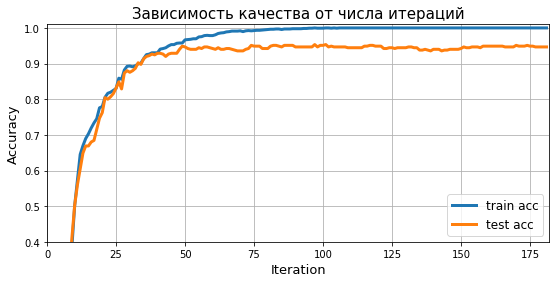

In [37]:
fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(4)

plt.plot(cb.train_acc, label="train acc", linewidth=3)
plt.plot(cb.test_acc, label="test acc", linewidth=3)
plt.xlabel("Iteration", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Зависимость качества от числа итераций", fontsize=15)
plt.xlim(0, len(cb.train_acc))
plt.ylim(0.4, 1.01)
plt.grid(True)
plt.legend(loc=4, fontsize='large')

plt.show()

## Эксперименты с числом слоев (2 балла)

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучать нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы accs_train и accs_test. В позиции [i, j] должна стоять величина точности сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [38]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [39]:
hidden_layers_size = 32

for i in range(0, 5):
    for j in range(0, 5):
        network = []
        if i == 0:
            network.append(Dense(X_train.shape[1], 10))
        else:
            network.append(Dense(X_train.shape[1], hidden_layers_size))
            network.append(ReLU())
            for k in range(0, i - 1):
                network.append(Dense(hidden_layers_size, hidden_layers_size))
                network.append(ReLU())
            network.append(Dense(hidden_layers_size, 10))
        network.append(Softmax())
        weights = get_weights(network)
        res = minimize(compute_loss_grad, weights, args=[network, X_train, y_train],
               method="L-BFGS-B", jac=True)
        set_weights(res["x"], network)
        y_pred_train = predict(network, X_train)
        y_train_ravel = y_train.argmax(axis=1)
        accs_train[i, j] = (y_train_ravel == y_pred_train).mean()
        y_pred_test = predict(network, X_test)
        y_test_ravel = y_test.argmax(axis=1)
        accs_test[i, j] = (y_test_ravel == y_pred_test).mean()


In [40]:
accs_train

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.10616184, 1.        , 1.        , 1.        , 1.        ]])

In [41]:
accs_test

array([[0.94222222, 0.94888889, 0.95111111, 0.94222222, 0.94666667],
       [0.96222222, 0.95555556, 0.95111111, 0.95777778, 0.95777778],
       [0.95777778, 0.96      , 0.95111111, 0.95777778, 0.93555556],
       [0.92666667, 0.95555556, 0.95555556, 0.95777778, 0.95333333],
       [0.08444444, 0.93333333, 0.94222222, 0.94222222, 0.94444444]])

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце - среднее, прямоугольник показывает разброс).

Text(0.5,1,'Test quality in 5 runs')

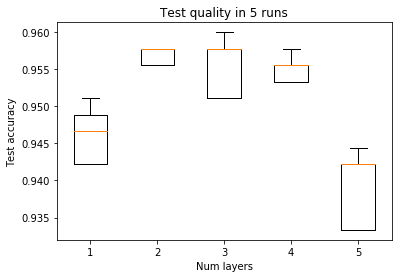

In [42]:
plt.boxplot(accs_test.T, showfliers=False)
plt.xlabel("Num layers")
plt.ylabel("Test accuracy")
plt.title("Test quality in 5 runs")

Ответьте на вопросы (кратко в этой же ячейке):
* Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?

При увеличении числа слоев до 3 качество обучения растет, затем с увеличением слоев начинает падать. Вместе с увеличением числа слоев также немного увеличивается и разброс.
* Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

Логистическая регрессия соотвествует в данном случае нейросети с одним полносвязным слоем. По графикам видно, что линейная модель дает меньшее качество, чем нейросеть с 2-4 слоями, но лучше чем при 5.

\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)

## Бонусная часть

## Реализация метода оптимизации (1 балл)

Реализуйте сами метод оптимизации (аналог функции minimize) для рассмотренной выше архитектуры. В качестве метода оптимизации используйте SGD + momentum. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с LBFGS-B. Сделайте выводы.

## Dropout (1 балл) 

Реализуйте слой Dropout. Сравните обучение сети из большого числа слоёв при использовании Dropout и без его использования (предварительно подберите адекватный параметр p). Сделайте выводы. Используя метод оптимизации из первого бонусного пункта. 

## BatchNormalization (1 балл)

Реализуйте слой BatchNormalization. Сравните обучение сети из большого числа слоёв при использовании BatchNormalization и без его использования.  Сделайте выводы. Используя метод оптимизации из первого бонусного пункта. 